In [1]:
import sys
import os
import numpy as np
import torch
import pandas as pd
import csv
import matplotlib.pyplot as plt
from scipy.stats import binom

In [2]:
# custom imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from src.utils import load_config
import src.graphs_generation as graphs_gen

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\danie\Desktop\Virtual Envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Common functions

Functions adapted from:
`\HUPLACLIP-NNs\scripts\visualizations\degree_distribution.ipynb`

In [3]:
def p_correction(p_nodes, graph_size, clique_size):
    '''Returns the value of the corrected p-value in the graph with clique ("p_reduce" case) '''
    p_corrected = (
        p_nodes * graph_size * (graph_size - 1)
        - clique_size * (clique_size - 1)
    ) / ((graph_size - clique_size) * (graph_size + clique_size - 1))
    return p_corrected

# P(d|C=0)
def p_noclique(degree_arr, graph_size):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITHOUT the clique) a node has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    NOTE: already log-transformed, to be used directly in decision variable computation.
    '''
    return binom.logpmf(degree_arr, 
                     graph_size-1, 
                     0.5    # "p_reduce" correction only acts on graph with clique
                     )

def degree_distribution_noclique(degree_arr, graph_size):
    '''
    Uses p_noclique to obtain the overall probability that (in a graph WITHOUT the clique) a node has exactly that degree.
    '''
    return p_noclique(degree_arr, graph_size)

# P(d|C=1)
def p_ingroup(degree_arr, graph_size, clique_size, p_corrected):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITH the clique) a node INSIDE the clique has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr - (clique_size-1),  # number of non-clique connections
                     graph_size - clique_size,      # number of possible non-clique nodes
                     p_corrected
                     )

def p_outgroup(degree_arr, graph_size, clique_size, p_corrected):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITH the clique) a node OUTSIDE the clique has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr, 
                     graph_size-1, 
                     p_corrected
                     )

def degree_distribution_clique(degree_arr, graph_size, clique_size, p_corrected):
    '''Combines p_outgroup and p_ingroup (single mixture) to obtain the overall probability that (in a graph WITH the clique) a node has exactly that degree'''
    epsilon = 1e-300
    prob = clique_size/graph_size * p_ingroup(degree_arr, graph_size, clique_size, p_corrected) + (1-clique_size/graph_size) * p_outgroup(degree_arr, graph_size, clique_size, p_corrected)    
    return prob + epsilon

# Ideal observers

## K known

### Definitions

Designed at SISSA on 06/08/2025

![Alt text](../../scripts/Ideal-observer_performance/whiteboard_images/ideal-observer_06-08-2025_k-known.png)

In [4]:
def ideal_observer_k_known(graphs_batch, graph_size, clique_size, p_corrected):
  # for each graph in the batch, compute the degree of each node and store in a 1-D array
  degrees = np.array(torch.sum(graphs_batch, dim=2))  # shape: (batch_size, 1, graph_size)
  # computing decision variable:
  decision_variable = np.sum(np.log(degree_distribution_clique(degrees, graph_size, clique_size, p_corrected)) - degree_distribution_noclique(degrees, graph_size), 2)  # shape: (batch_size, 1)
  # Convert values > 0 to 1, values <= 0 to 0
  hard_output = (decision_variable > 0).astype(int)
  return hard_output.squeeze()

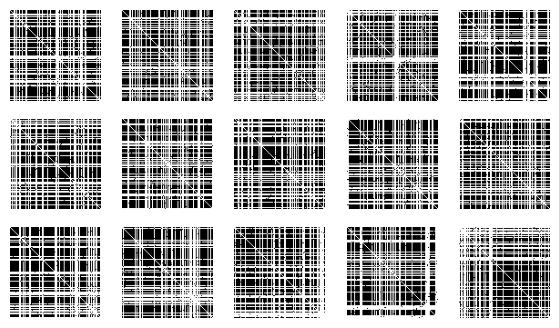

Fraction of correct responses:
1.0


In [5]:
# test of model on a very easy instance:
# visualizing input for graph of 100 nodes and clique of 70, "p_reduce"
graphs_with_clique = graphs_gen.generate_batch(15, 100, np.repeat([70],15), "p_reduce", False, p_clique=1)
# Show 15 graphs
fig, axes = plt.subplots(3, 5, figsize=(7, 4))
for i in range(15):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(np.squeeze(graphs_with_clique[0][i]), cmap='gray_r')
    axes[row, col].axis('off')
plt.show()
# testing ideal observer on this batch:
p_corrected = p_correction(0.5, 100, 70)
decision_variable = ideal_observer_k_known(graphs_with_clique[0], 100, 70, p_corrected)
print("Fraction of correct responses:")
print(np.sum(decision_variable == graphs_with_clique[1]) / 15)

### Testing

In [6]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-observer_test_config.yml")
)
    
# looping over the different graph sizes in the experiment:
for graph_size in config["graph_size_values"]:

    # Create empty dictionaries for storing testing results:
    fraction_correct_results = {}  # Fraction correct for each clique size
    metrics_results_list = []

    # Calculate max clique size for testing (proportion of graph size):
    if graph_size in [100, 150, 200]:
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][0]
    elif graph_size in [300, 400, 480, 600]:
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][1]
    elif graph_size in [800, 1000, 1200]:
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][2]                        
    elif graph_size in [1500, 2000]:
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][3]                            
    elif graph_size in [3000, 5000]:
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][4]
    else:
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][5]
    max_clique_size = int(
        max_clique_size_proportion_test * graph_size
    )

    # Calculate array of clique sizes for all test curriculum
    # NOTE: if max clique size is smaller than the the number of test levels, use max clique size as the number of test levels
    clique_sizes = np.linspace(
        max_clique_size,
        1,
        num=min(max_clique_size, config["testing_parameters"]["clique_testing_levels"]),
    ).astype(int)

    # Loop for decreasing clique sizes
    for current_clique_size in clique_sizes:

        # Computing value of p_corrected for current N/K combination
        p_corrected = p_correction(0.5, graph_size, current_clique_size)

        # Metrics initialization (for each clique size)
        TP, FP, TN, FN = 0, 0, 0, 0  

        # Initialize fraction correct list, updated at each test iteration
        fraction_correct_list = []

        # Loop for testing iterations:
        for test_iter in range(config["testing_parameters"]["test_iterations"]):

            # Generate clique size value of each graph in the current batch
            clique_size_array_test = graphs_gen.generate_batch_clique_sizes(
                np.array([current_clique_size]),
                config["testing_parameters"]["num_test"],
            )

            # Generate validation graphs
            test = graphs_gen.generate_batch(
                config["testing_parameters"]["num_test"],
                graph_size,
                clique_size_array_test,
                config["p_correction_type"],
                False,
            )
                        
            hard_output = ideal_observer_k_known(test[0], graph_size, current_clique_size, p_corrected)
            test_labels = np.array(test[1]) # convert list to numpy array
            # print(hard_output.shape, test_labels.shape)   # DEBUGGING

            # transforming hard_output and test_labels to torch tensors:
            hard_output = torch.tensor(hard_output, dtype=torch.float32)
            test_labels = torch.tensor(test[1], dtype=torch.float32)
            
            # Compute metrics
            TP += ((hard_output == 1) & (test_labels == 1)).sum().item()
            FP += ((hard_output == 1) & (test_labels == 0)).sum().item()
            TN += ((hard_output == 0) & (test_labels == 0)).sum().item()
            FN += ((hard_output == 0) & (test_labels == 1)).sum().item()

            # updating fraction correct list with the accuracy of the current test iteration:
            fraction_correct_list.append(
                (hard_output == test_labels).sum().item()
                / (1.0 * config["testing_parameters"]["num_test"])
            )

        # Updating dictionary after all test iterations for current clique size have been completed:
        fraction_correct_results[current_clique_size] = round(
            sum(fraction_correct_list) / len(fraction_correct_list), 2
        )
        
        # Computing metrics:
        precision = TP / (TP + FP + 1e-10)
        recall = TP / (TP + FN + 1e-10)
        F1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        # AUC - ROC cannot be calculated (no soft outputs)
        # num_params has no meaning
        metrics_results = {
            "N_value": graph_size,
            "clique_size": current_clique_size,
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "precision": precision,
            "recall": recall,
            "F1": F1,
        }
        metrics_results_list.append(metrics_results)        

        # Printing the size of the clique just tested and the corresponding test accuracy:
        print(
            f"||| Completed testing for clique = {current_clique_size}. "
            f"Average fraction correct = {fraction_correct_results[current_clique_size]}"
        )
        print("|||===========================================================")

    # - notify completion of testing:
    print(f"| Finished testing Ideal observer at N = {graph_size}.")

    # Saving accuracy results in .csv file:
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", "ideal-observer-k-known", f"Ideal-observer-k-known_N{graph_size}_fraction_correct.csv"
    )
    # - saving the dictionary as a .csv file:
    with open(file_path, "w") as file:
        writer = csv.writer(file)
        writer.writerow(["clique size", "fraction correct"])  # Add column labels
        for key, value in fraction_correct_results.items():
            writer.writerow([key, value])
    # Saving metrics results in .csv file:
    metrics_df = pd.DataFrame(metrics_results_list)    
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", "ideal-observer-k-known", f"Ideal-observer-k-known_N{graph_size}_metrics.csv"
    )
    metrics_df.to_csv(file_path, index=False)

    print(f"- Ideal observer Results saved successfully for N = {graph_size}.")

Configuration file loaded successfully.
||| Completed testing for clique = 200. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 197. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 195. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 193. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 191. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 189. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 187. Average fraction correct = 0.97
|||===========================================================
||| Completed testing

### Metrics analysis

The hypothesis is that FP>FN  for small K values in the `ideal-observer-k-not-known` model, while this should't be the case for the `k-known` case

Configuration file loaded successfully.


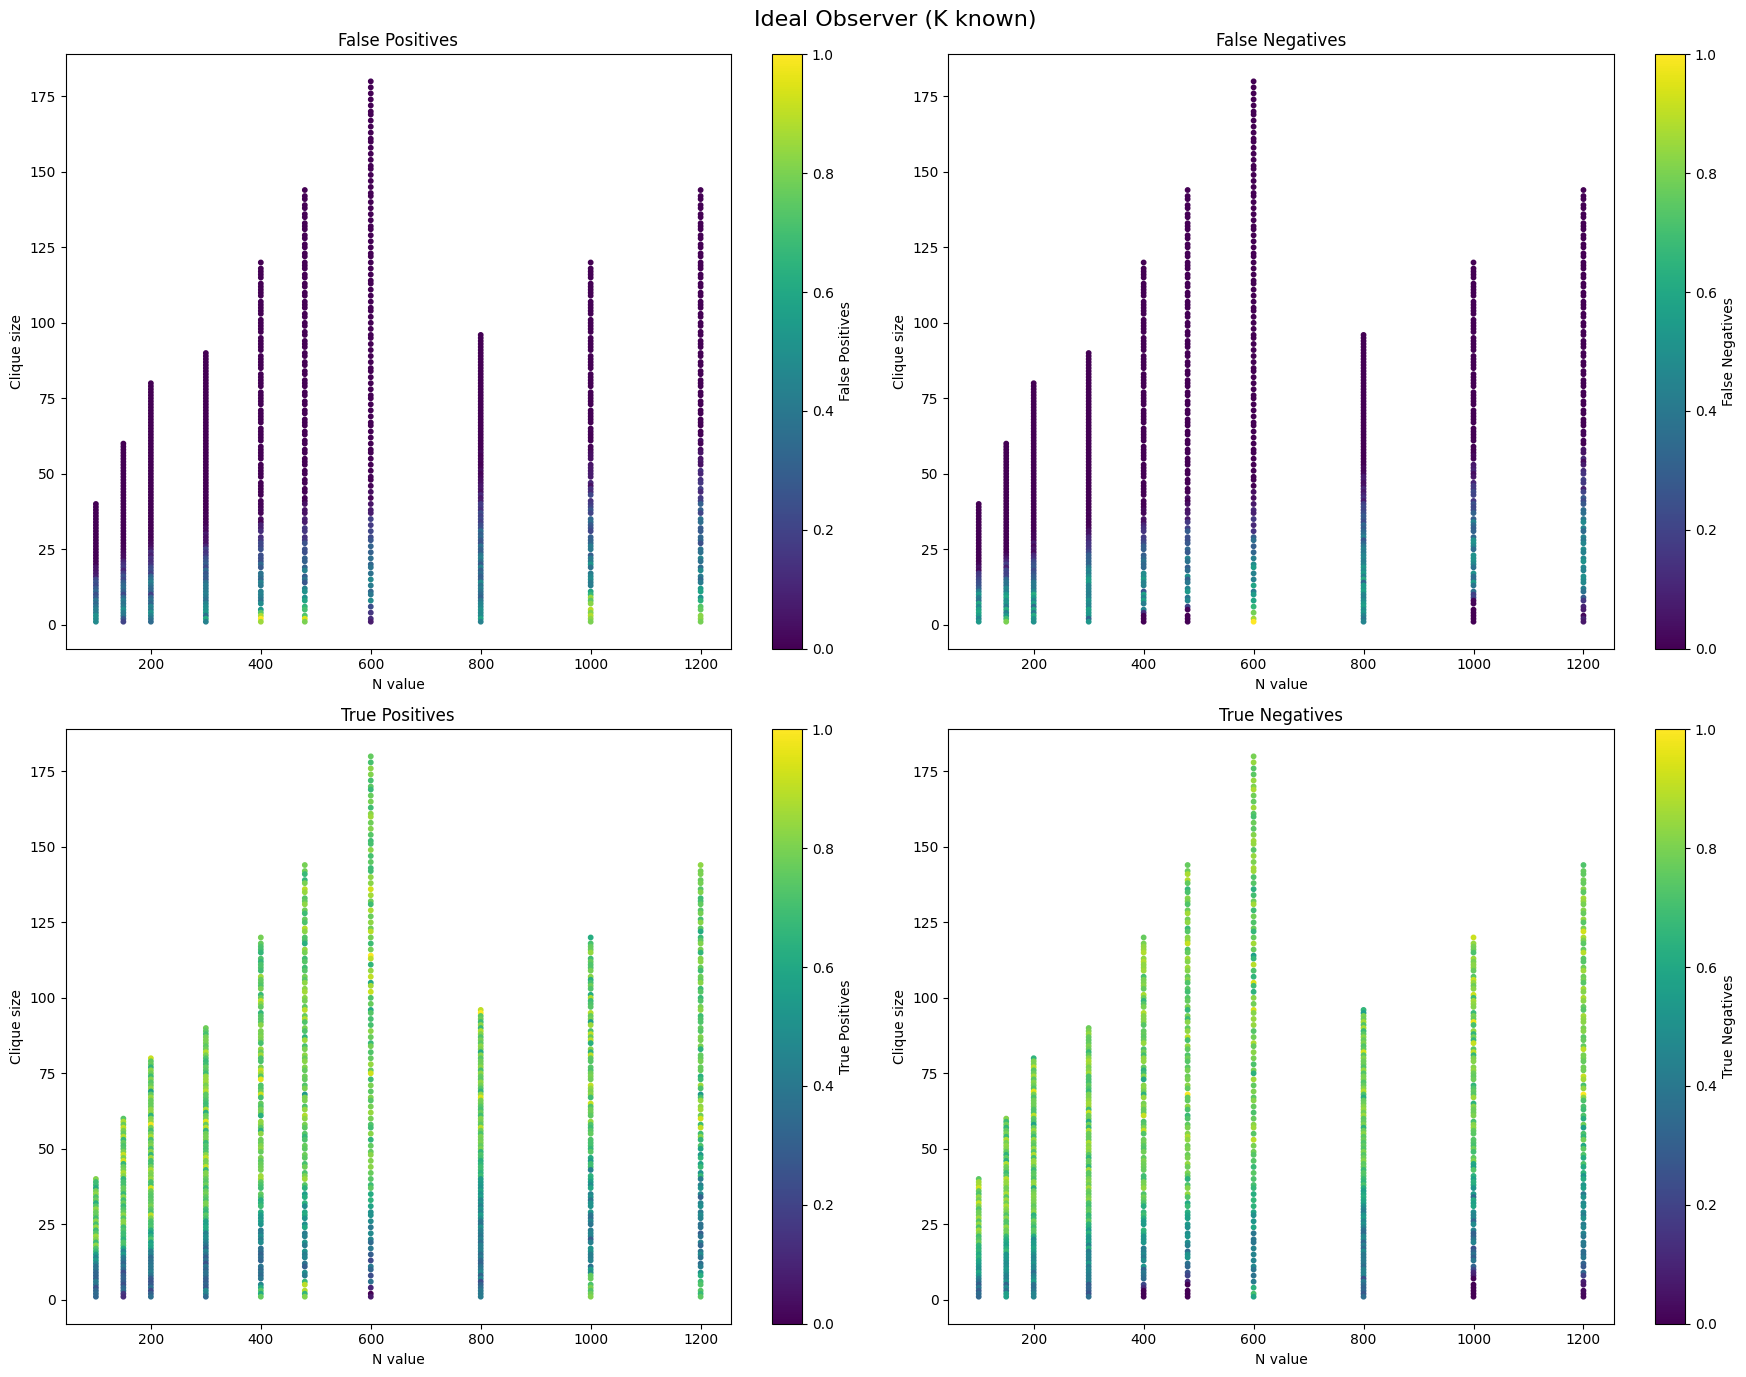

In [ ]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-observer_test_config.yml")
)
global_metric_df = pd.DataFrame()
    
# looping over the different graph sizes in the experiment:
for graph_size in [100, 150, 200, 300, 400, 480, 600, 800, 1000, 1200]:
    file_path = os.path.join(os.getcwd(), "results", "ideal-observer-k-known", f"Ideal-observer-k-known_N{graph_size}_metrics.csv")
    metrics_df = pd.read_csv(file_path)
    global_metric_df = pd.concat([global_metric_df, metrics_df], ignore_index=True)

# normalizing (min-max normalization) metrics for better visualization:
cols_to_visualize = ['FP', 'FN', 'TP', 'TN']
global_metric_df[cols_to_visualize] = (global_metric_df[cols_to_visualize] - global_metric_df[cols_to_visualize].min()) / (global_metric_df[cols_to_visualize].max() - global_metric_df[cols_to_visualize].min())

# Visualizing FP, FN, TP, TN in a 2x2 grid with N value on the x-axis and clique size on the y-axis (color-coded):
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
metrics = ['FP', 'FN', 'TP', 'TN']
titles = ['False Positives', 'False Negatives', 'True Positives', 'True Negatives']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    im = ax.scatter(
        global_metric_df['N_value'],
        global_metric_df['clique_size'],
        c=global_metric_df[metric],
        cmap='viridis',
        s=10
    )
    ax.set_title(title)
    ax.set_xlabel('N value')
    ax.set_ylabel('Clique size')
    fig.colorbar(im, ax=ax, label=title)
plt.suptitle('Ideal Observer (K known)', fontsize=16)

plt.tight_layout()
plt.show()


## K not known

### Definitions

Designed at SISSA on 08/08/2025

![Alt text](../../scripts/Ideal-observer_performance/whiteboard_images/ideal-observer_08-08-2025_k-not-known.jpg)

In [4]:
def ideal_observer_k_not_known(graphs_batch, graph_size, clique_size_values, p_corrected_values):
    # NOTE: "clique_size_values" and "p_corrected_values" are arrays of the possible K values and the corresponding p_corrected values
    batch_size = len(graphs_batch)
    n_clique_size_values = len(clique_size_values)
    # for each graph in the batch, compute the degree of each node and store in a 1-D array
    degrees = np.array(torch.sum(graphs_batch, dim=2))  # shape: (batch_size, 1, graph_size)
    # broadcasting degrees so that they can be used in formula for different clique size values
    degrees_broadcast = np.broadcast_to(degrees, (batch_size, n_clique_size_values, graph_size)) # shape: (batch_size, n_clique_size_values, graph_size)
    # reshaping clique size values so that they can be broadcasted
    clique_size_values_broadcast = np.reshape(clique_size_values, (1, n_clique_size_values, 1))  # shape: (1, n_clique_size_values, 1)  
    # reshaping p_corrected so that it can be broadcasted
    p_corrected_broadcast = np.reshape(p_corrected_values, (1, n_clique_size_values, 1))  # shape: (1, n_clique_size_values, 1)  
    
    # # 1st VERSION ("p_clique" = -inf (underflow) at large graph_size values)
    # # Compute degree distribution for all graphs and all clique sizes ("np.prod" is over graph_size dimension; "np.sum" is over n_clique_size_values dimension)
    # p_clique = np.log(
    #             (np.sum(
    #                 np.prod(degree_distribution_clique(degrees_broadcast, graph_size, clique_size_values_broadcast, p_corrected_broadcast),
    #                 axis = 2),
    #             axis = 1))
    #             / n_clique_size_values) # final shape: (batch_size, 1, 1)     
    
    # 2nd VERSION (with log-sum-exp trick to avoid underflow)
    sigma_kprime = np.sum(
        np.log(degree_distribution_clique(
            degrees_broadcast, graph_size, clique_size_values_broadcast, p_corrected_broadcast
        )),
        axis=2  # sum over nodes
    )  # shape: (batch_size, n_clique_size_values) -> all negative values
    
    sigma_star = np.max(sigma_kprime, axis=1, keepdims=True)   # maximum over "clique size" axis (shape: (15, 1) )
    
    # computing p_clique:   
    p_clique = sigma_star + np.log(np.sum(np.exp(sigma_kprime - sigma_star), axis = 1, keepdims=True)) - np.log(n_clique_size_values)  # shape: (batch_size, 1)
    
    # sanity check to make sure p_clique has no +/- inf:
    if p_clique.dtype == np.float64:
        if np.isinf(p_clique).any() or np.isnan(p_clique).any():
            raise ValueError("p_clique contains inf or NaN values, check numerical stability and logsumexp effectiveness.")
    
    # # DEBUGGING
    # print("Clique probabilities for all graphs:")
    # print(p_clique.squeeze())
    # print("No clique probabilities for all graphs:")
    # print(np.sum(degree_distribution_noclique(degrees, graph_size), 2).squeeze())

    # computing decision variable
    decision_variable = p_clique.squeeze() - np.sum(degree_distribution_noclique(degrees, graph_size), 2).squeeze()
    # Convert values > 0 to 1, values <= 0 to 0
    hard_output = (decision_variable > 0).astype(int)

    # # DEBUGGING
    # print("Hard output:")
    # print(hard_output)

    return hard_output.squeeze()

Clique size of:  60  in a graph of size:  1200


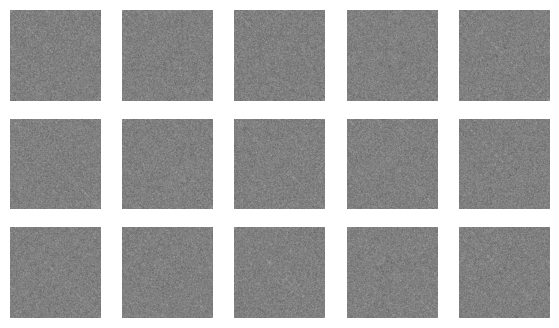

Fraction of correct responses:
0.8666666666666667


In [5]:
# test of model on task instance
N_value = 1200   #CHANGE THIS
clique_size_fraction = 0.05 # CHANGE THIS
print("Clique size of: ", int(clique_size_fraction*N_value), " in a graph of size: ", N_value)
# visualizing input for 15 graphs, "p_reduce"
graphs_with_clique = graphs_gen.generate_batch(15, N_value, np.repeat([int(clique_size_fraction*N_value)],15), "p_reduce", False, p_clique=1)
# Show 15 graphs
fig, axes = plt.subplots(3, 5, figsize=(7, 4))
for i in range(15):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(np.squeeze(graphs_with_clique[0][i]), cmap='gray_r')
    axes[row, col].axis('off')
plt.show()
# testing ideal observer on this graph:
clique_size_values = np.arange(1, int(0.7*N_value) + 1, 1)  # clique sizes from 1 to N/2
p_corrected_values = p_correction(0.5, N_value, clique_size_values)

# DEBUGGING
# print("Clique size values:")
# print(clique_size_values)
# print("p_corrected values:")
# print(p_corrected_values)

decision_variable = ideal_observer_k_not_known(graphs_with_clique[0], N_value, clique_size_values, p_corrected_values)
print("Fraction of correct responses:")
print(np.sum(decision_variable == graphs_with_clique[1]) / 15)

### Testing

In [ ]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-observer_test_config.yml")
)
    
# looping over the different graph sizes in the experiment:
for graph_size in config["graph_size_values"]:

    # Calculate max clique size for testing (proportion of graph size):
    if graph_size in [100, 150, 200]:
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][0]
    elif graph_size in [300, 400, 480, 600]:
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][1]
    elif graph_size in [800, 1000, 1200]:
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][2]                        
    elif graph_size in [1500, 2000]:
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][3]                            
    elif graph_size in [3000, 5000, 10000]:
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][4]
    # else:
    #     max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][5]
    max_clique_size = int(
        max_clique_size_proportion_test * graph_size
    )

    # defining priors for clique sizes at current graph size:
    stat_limit = round(2 * np.log2(graph_size))
    clique_size_values = np.arange(stat_limit, (max_clique_size_proportion_test * graph_size) + 1 )
    print("Clique size values for prior: ", clique_size_values)
    # defining corresponding p_corrected values:
    p_corrected_values = p_correction(0.5, graph_size, clique_size_values)
    print("P-corrected values for each clique size value: ", p_corrected_values)
    
    # Create empty dictionaries for storing testing results:
    fraction_correct_results = {}  # Fraction correct for each clique size
    metrics_results_list = []

    # Calculate array of clique sizes for all test curriculum
    # NOTE: if max clique size is smaller than the the number of test levels, use max clique size as the number of test levels
    clique_sizes = np.linspace(
        max_clique_size,
        1,
        num=min(max_clique_size, config["testing_parameters"]["clique_testing_levels"]),
    ).astype(int)

    # Loop for decreasing clique sizes
    for current_clique_size in clique_sizes:

        # Metrics initialization (for each clique size)
        TP, FP, TN, FN = 0, 0, 0, 0  

        # Initialize fraction correct list, updated at each test iteration
        fraction_correct_list = []

        # Loop for testing iterations:
        for test_iter in range(config["testing_parameters"]["test_iterations"]):

            # Generate clique size value of each graph in the current batch
            clique_size_array_test = graphs_gen.generate_batch_clique_sizes(
                np.array([current_clique_size]),
                config["testing_parameters"]["num_test"],
            )

            # Generate validation graphs
            test = graphs_gen.generate_batch(
                config["testing_parameters"]["num_test"],
                graph_size,
                clique_size_array_test,
                config["p_correction_type"],
                False,
            )
                        
            hard_output = ideal_observer_k_not_known(test[0], graph_size, clique_size_values, p_corrected_values)
            test_labels = np.array(test[1]) # convert list to numpy array
            # print(hard_output.shape, test_labels.shape)   # DEBUGGING

            # transforming hard_output and test_labels to torch tensors:
            hard_output = torch.tensor(hard_output, dtype=torch.float32)
            test_labels = torch.tensor(test[1], dtype=torch.float32)
            
            # Compute metrics
            TP += ((hard_output == 1) & (test_labels == 1)).sum().item()
            FP += ((hard_output == 1) & (test_labels == 0)).sum().item()
            TN += ((hard_output == 0) & (test_labels == 0)).sum().item()
            FN += ((hard_output == 0) & (test_labels == 1)).sum().item()

            # updating fraction correct list with the accuracy of the current test iteration:
            fraction_correct_list.append(
                (hard_output == test_labels).sum().item()
                / (1.0 * config["testing_parameters"]["num_test"])
            )
            
            # delete unused variables
            del test, hard_output, test_labels, clique_size_array_test

        # Updating dictionary after all test iterations for current clique size have been completed:
        fraction_correct_results[current_clique_size] = round(
            sum(fraction_correct_list) / len(fraction_correct_list), 2
        )
        
        # Computing metrics:
        precision = TP / (TP + FP + 1e-10)
        recall = TP / (TP + FN + 1e-10)
        F1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        # AUC - ROC cannot be calculated (no soft outputs)
        # num_params has no meaning
        metrics_results = {
            "N_value": graph_size,
            "clique_size": current_clique_size,
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "precision": precision,
            "recall": recall,
            "F1": F1,
        }
        metrics_results_list.append(metrics_results)

        # Printing the size of the clique just tested and the corresponding test accuracy:
        print(
            f"||| Completed testing for clique = {current_clique_size}. "
            f"Average fraction correct = {fraction_correct_results[current_clique_size]}"
        )
        print("|||===========================================================")


    # - notify completion of testing:
    print(f"| Finished testing Ideal observer at N = {graph_size}.")

    # Saving accuracy results in .csv file:
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", "ideal-observer-k-not-known", f"Ideal-observer-k-not-known_N{graph_size}_fraction_correct.csv"
    )
    # - saving the dictionary as a .csv file:
    with open(file_path, "w") as file:
        writer = csv.writer(file)
        writer.writerow(["clique size", "fraction correct"])  # Add column labels
        for key, value in fraction_correct_results.items():
            writer.writerow([key, value])
    # Saving metrics results in .csv file:
    metrics_df = pd.DataFrame(metrics_results_list)    
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", "ideal-observer-k-not-known", f"Ideal-observer-k-not-known_N{graph_size}_metrics.csv"
    )
    metrics_df.to_csv(file_path, index=False)

    print(f"- Ideal observer Results saved successfully for N = {graph_size}.")

Configuration file loaded successfully.
Clique size values for prior:  [ 27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194.
 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 207. 208.
 209. 

### Metrics analysis

The hypothesis is that FN>FP  for small K values in the `ideal-observer-k-not-known` model (compared to when K is known).

Configuration file loaded successfully.


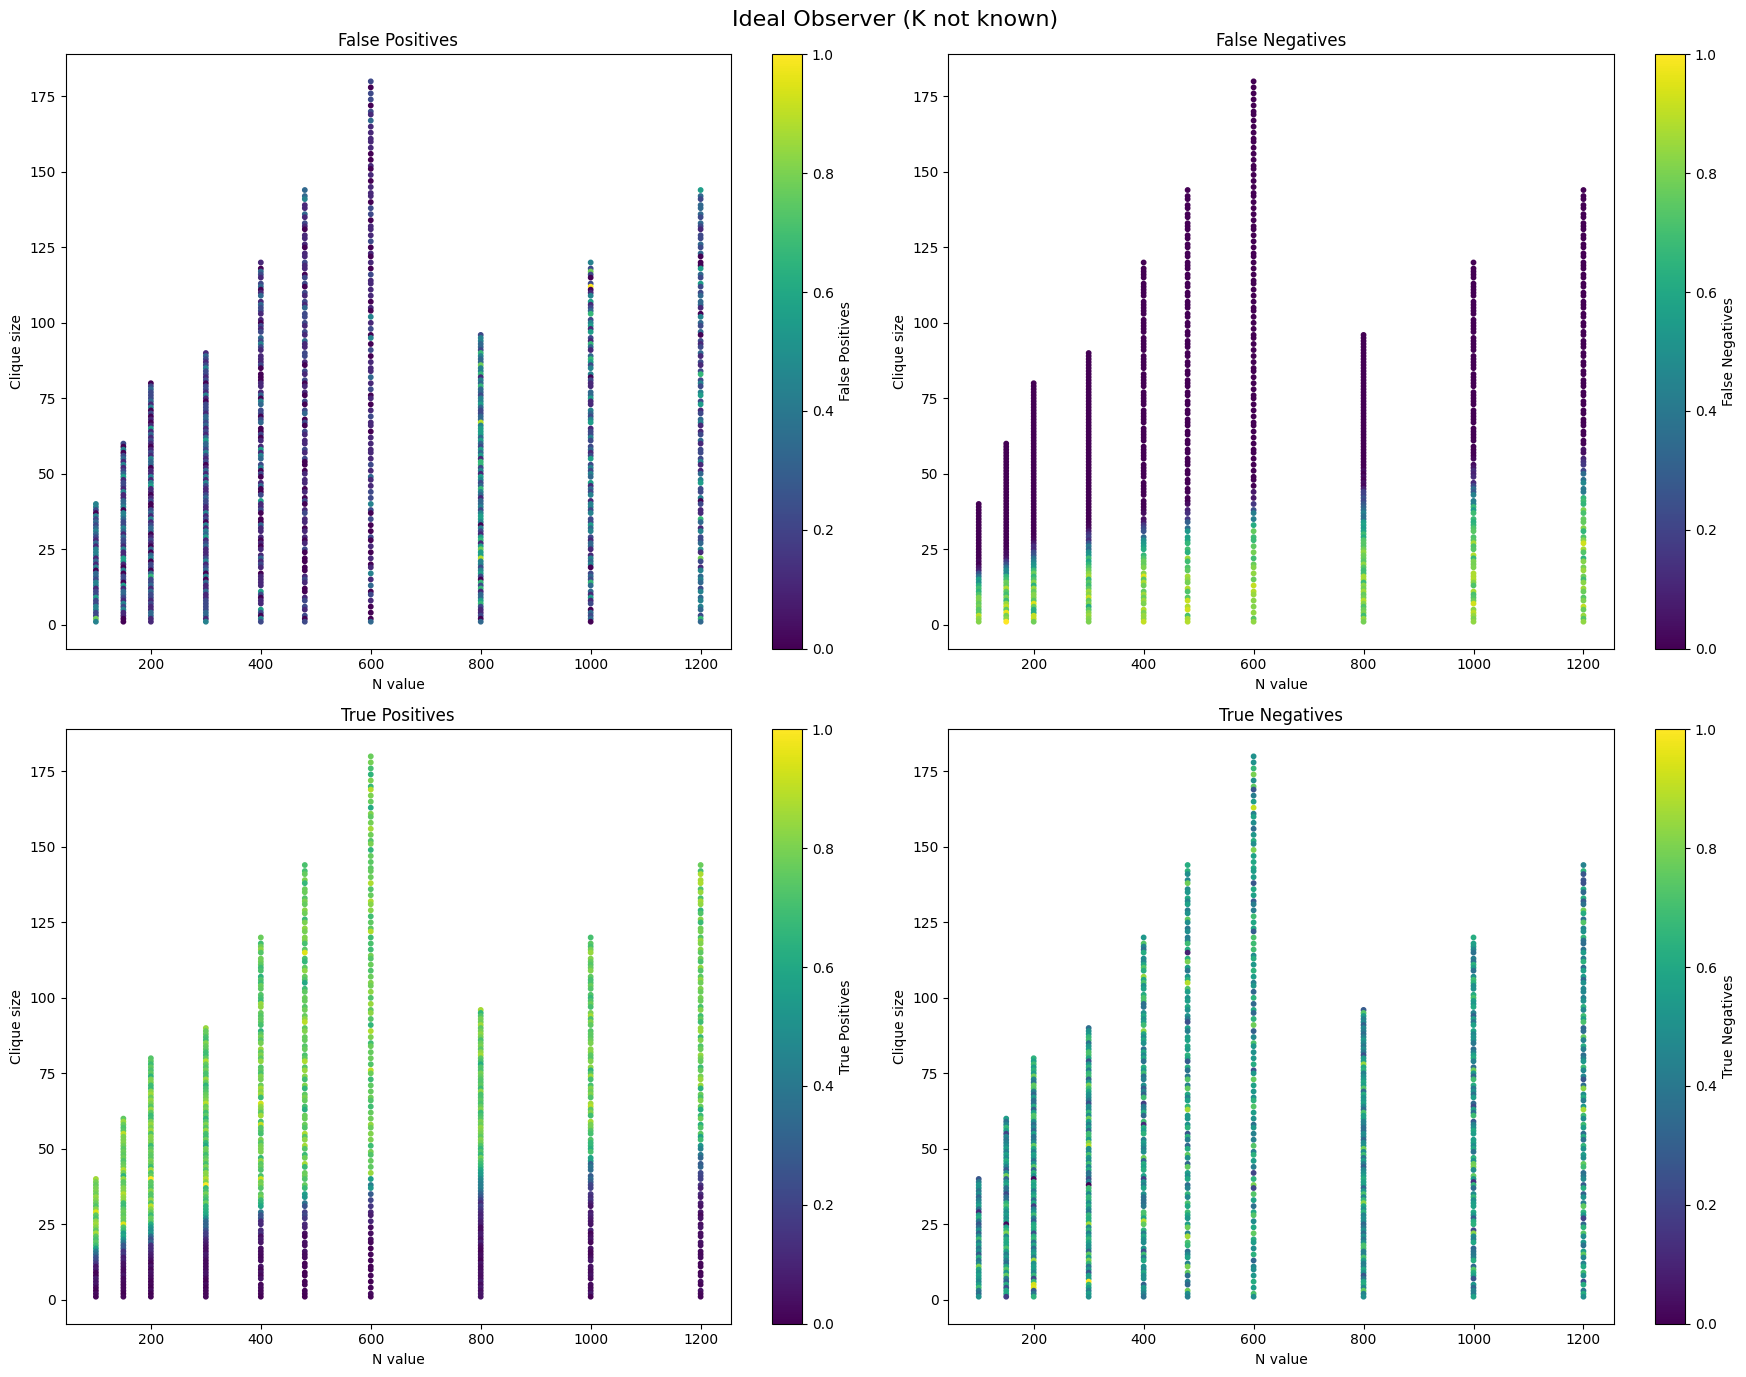

In [7]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-observer_test_config.yml")
)
global_metric_df = pd.DataFrame()
    
# looping over the different graph sizes in the experiment:
for graph_size in [100, 150, 200, 300, 400, 480, 600, 800, 1000, 1200, 1500, 2000, 3000, 5000]:
    file_path = os.path.join(os.getcwd(), "results", "ideal-observer-k-not-known", f"Ideal-observer-k-not-known_N{graph_size}_metrics.csv")
    metrics_df = pd.read_csv(file_path)
    global_metric_df = pd.concat([global_metric_df, metrics_df], ignore_index=True)

# normalizing (min-max normalization) metrics for better visualization:
cols_to_visualize = ['FP', 'FN', 'TP', 'TN']
global_metric_df[cols_to_visualize] = (global_metric_df[cols_to_visualize] - global_metric_df[cols_to_visualize].min()) / (global_metric_df[cols_to_visualize].max() - global_metric_df[cols_to_visualize].min())

# Visualizing FP, FN, TP, TN in a 2x2 grid with N value on the x-axis and clique size on the y-axis (color-coded):
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
metrics = ['FP', 'FN', 'TP', 'TN']
titles = ['False Positives', 'False Negatives', 'True Positives', 'True Negatives']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    im = ax.scatter(
        global_metric_df['N_value'],
        global_metric_df['clique_size'],
        c=global_metric_df[metric],
        cmap='viridis',
        s=10
    )
    ax.set_title(title)
    ax.set_xlabel('N value')
    ax.set_ylabel('Clique size')
    fig.colorbar(im, ax=ax, label=title)
plt.suptitle('Ideal Observer (K not known)', fontsize=16)    

plt.tight_layout()
plt.show()


## K matched with K grid in human experiments

### Definitions

This model is simply a version of `ideal_observer_k_not_known` where `clique_size_values` and `p_corrected_values` are matched with the K values in the human experiments.

In [14]:
# defining grid of K values (sqrt-grid) used in human experiments:
K_grid_human_exps = {
    100: np.array([58, 52, 47, 44, 41, 38, 35, 33, 30, 28, 25, 23, 20, 18, 16, 11,  6]),
    150: np.array([90, 82, 73, 68, 64, 60, 55, 51, 47, 43, 39, 36, 32, 28, 25, 17, 10]),
    200: np.array([114, 103,  92,  86,  81,  75,  70,  64,  59,  54,  50,  45, 40, 36,  31,  22,  13]),
    300: np.array([150, 136, 121, 114, 107,  99,  92,  85,  78,  72,  66,  59,  53, 47,  41,  29,  17]),
    400: np.array([180, 162, 145, 136, 127, 118, 110, 101,  93,  86,  78,  71,  63, 56,  49,  34,  20]),
    480: np.array([200, 181, 161, 151, 142, 132, 123, 113, 103,  95,  87,  79,  71, 63,  55,  38,  22]),
    600: np.array([227, 205, 183, 172, 161, 150, 139, 128, 117, 108,  99,  89,  80, 71,  62,  43,  25]),
    800: np.array([266, 240, 215, 201, 189, 176, 163, 150, 137, 127, 116, 105,  94, 83,  73,  51,  29]),
    1000: np.array([300, 271, 242, 227, 213, 198, 184, 169, 155, 143, 131, 118, 106, 94,  82,  57,  33])
}
print(K_grid_human_exps[100])

[58 52 47 44 41 38 35 33 30 28 25 23 20 18 16 11  6]


Clique size of:  50  in a graph of size:  1000


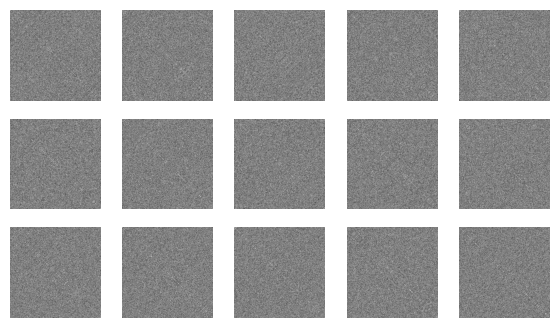

Fraction of correct responses:
0.5333333333333333


In [15]:
# test of model on task instance
N_value = 1000   #CHANGE THIS
clique_size_fraction = 0.05 # CHANGE THIS
print("Clique size of: ", int(clique_size_fraction*N_value), " in a graph of size: ", N_value)
# visualizing input for 15 graphs, "p_reduce"
graphs_with_clique = graphs_gen.generate_batch(15, N_value, np.repeat([int(clique_size_fraction*N_value)],15), "p_reduce", False, p_clique=1)
# Show 15 graphs
fig, axes = plt.subplots(3, 5, figsize=(7, 4))
for i in range(15):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(np.squeeze(graphs_with_clique[0][i]), cmap='gray_r')
    axes[row, col].axis('off')
plt.show()
# testing ideal observer on this graph:
clique_size_values = K_grid_human_exps[N_value]
p_corrected_values = p_correction(0.5, N_value, clique_size_values)

# DEBUGGING
# print("Clique size values:")
# print(clique_size_values)
# print("p_corrected values:")
# print(p_corrected_values)

decision_variable = ideal_observer_k_not_known(graphs_with_clique[0], N_value, clique_size_values, p_corrected_values)
print("Fraction of correct responses:")
print(np.sum(decision_variable == graphs_with_clique[1]) / 15)

### Testing

In [ ]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-observer_test_config.yml")
)
    
# looping over the different graph sizes in the experiment:
for graph_size in config["graph_size_values"]:

    # defining priors for clique sizes at current graph size (aligned with grid for human experiment)
    clique_size_values = K_grid_human_exps[graph_size]
    print("Clique size values for prior: ", clique_size_values)
    # defining corresponding p_corrected values:
    p_corrected_values = p_correction(0.5, graph_size, clique_size_values)
    print(f"P-corrected values for each clique size value (N={graph_size}): {p_corrected_values}")
    
    # Create empty dictionaries for storing testing results:
    fraction_correct_results = {}  # Fraction correct for each clique size
    metrics_results_list = []

    # Calculate max clique size for testing (proportion of graph size):
    if graph_size in [100, 150, 200]:
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][0]
    elif graph_size in [300, 400, 480, 600]:
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][1]
    else:
        max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][2]                        
    max_clique_size = int(
        max_clique_size_proportion_test * graph_size
    )

    # Calculate array of clique sizes for all test curriculum
    # NOTE: if max clique size is smaller than the the number of test levels, use max clique size as the number of test levels
    clique_sizes = np.linspace(
        max_clique_size,
        1,
        num=min(max_clique_size, config["testing_parameters"]["clique_testing_levels"]),
    ).astype(int)

    # Loop for decreasing clique sizes
    for current_clique_size in clique_sizes:

        # Metrics initialization (for each clique size)
        TP, FP, TN, FN = 0, 0, 0, 0  

        # Initialize fraction correct list, updated at each test iteration
        fraction_correct_list = []

        # Loop for testing iterations:
        for test_iter in range(config["testing_parameters"]["test_iterations"]):

            # Generate clique size value of each graph in the current batch
            clique_size_array_test = graphs_gen.generate_batch_clique_sizes(
                np.array([current_clique_size]),
                config["testing_parameters"]["num_test"],
            )

            # Generate validation graphs
            test = graphs_gen.generate_batch(
                config["testing_parameters"]["num_test"],
                graph_size,
                clique_size_array_test,
                config["p_correction_type"],
                False,
            )
                        
            hard_output = ideal_observer_k_not_known(test[0], graph_size, clique_size_values, p_corrected_values)
            test_labels = np.array(test[1]) # convert list to numpy array
            # print(hard_output.shape, test_labels.shape)   # DEBUGGING

            # transforming hard_output and test_labels to torch tensors:
            hard_output = torch.tensor(hard_output, dtype=torch.float32)
            test_labels = torch.tensor(test[1], dtype=torch.float32)
            
            # Compute metrics
            TP += ((hard_output == 1) & (test_labels == 1)).sum().item()
            FP += ((hard_output == 1) & (test_labels == 0)).sum().item()
            TN += ((hard_output == 0) & (test_labels == 0)).sum().item()
            FN += ((hard_output == 0) & (test_labels == 1)).sum().item()

            # updating fraction correct list with the accuracy of the current test iteration:
            fraction_correct_list.append(
                (hard_output == test_labels).sum().item()
                / (1.0 * config["testing_parameters"]["num_test"])
            )

        # Updating dictionary after all test iterations for current clique size have been completed:
        fraction_correct_results[current_clique_size] = round(
            sum(fraction_correct_list) / len(fraction_correct_list), 2
        )
        
        # Computing metrics:
        precision = TP / (TP + FP + 1e-10)
        recall = TP / (TP + FN + 1e-10)
        F1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        # AUC - ROC cannot be calculated (no soft outputs)
        # num_params has no meaning
        metrics_results = {
            "N_value": graph_size,
            "clique_size": current_clique_size,
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "precision": precision,
            "recall": recall,
            "F1": F1,
        }
        metrics_results_list.append(metrics_results)

        # Printing the size of the clique just tested and the corresponding test accuracy:
        print(
            f"||| Completed testing for clique = {current_clique_size}. "
            f"Average fraction correct = {fraction_correct_results[current_clique_size]}"
        )
        print("|||===========================================================")


    # - notify completion of testing:
    print(f"| Finished testing Ideal observer at N = {graph_size}.")

    # Saving accuracy results in .csv file:
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", "ideal-observer-k-not-known_human-grid", f"Ideal-observer-k-not-known_human-grid_N{graph_size}_fraction_correct.csv"
    )
    # - saving the dictionary as a .csv file:
    with open(file_path, "w") as file:
        writer = csv.writer(file)
        writer.writerow(["clique size", "fraction correct"])  # Add column labels
        for key, value in fraction_correct_results.items():
            writer.writerow([key, value])
    # Saving metrics results in .csv file:
    metrics_df = pd.DataFrame(metrics_results_list)    
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", "ideal-observer-k-not-known_human-grid", f"Ideal-observer-k-not-known_human-grid_N{graph_size}_metrics.csv"
    )
    metrics_df.to_csv(file_path, index=False)

    print(f"- Ideal observer Results (human grid) saved successfully for N = {graph_size}.")

Configuration file loaded successfully.
Clique size values for prior:  [300 271 242 227 213 198 184 169 155 143 131 118 106  94  82  57  33]
P-corrected values for each clique size value (N=1000): [0.45067634 0.46048411 0.46900002 0.47293336 0.47632946 0.47968425
 0.4825593  0.48537412 0.48776061 0.48962597 0.49132866 0.49299326
 0.49436667 0.495586   0.49665343 0.49839728 0.49947091]
||| Completed testing for clique = 120. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 118. Average fraction correct = 0.99
|||===========================================================
||| Completed testing for clique = 117. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 116. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 115. Average fraction correct = 1.0
|||=

### Metrics analysis

The hypothesis is that FN>FP for small K values in the `ideal-observer-k-not-known` model (compared to when K is known).

Configuration file loaded successfully.


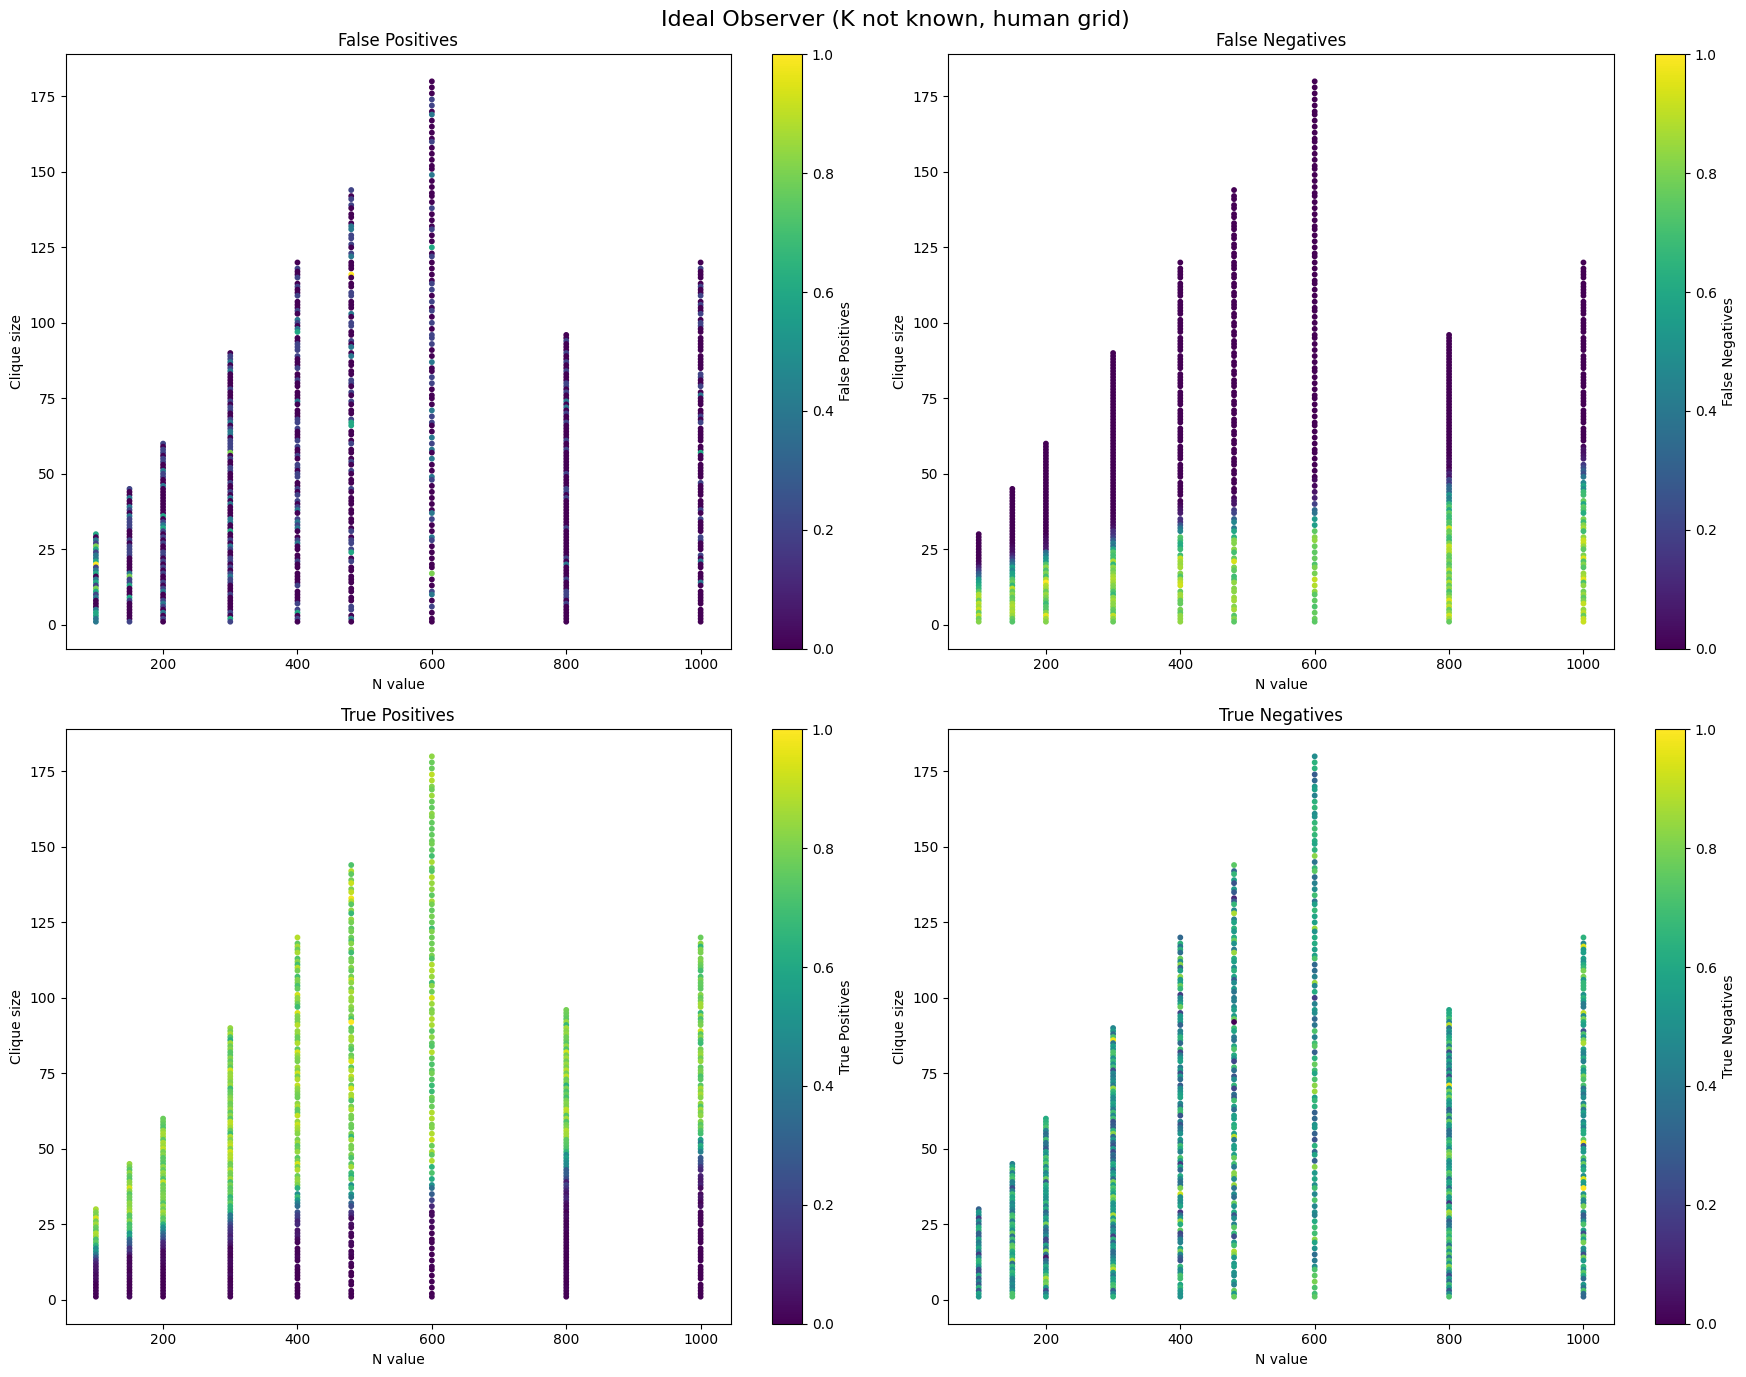

In [ ]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-observer_test_config.yml")
)
global_metric_df = pd.DataFrame()
    
# looping over the different graph sizes in the experiment:
for graph_size in [100, 150, 200, 300, 400, 480, 600, 800, 1000]:
    file_path = os.path.join(os.getcwd(), "results", "ideal-observer-k-not-known_human-grid", f"Ideal-observer-k-not-known_human-grid_N{graph_size}_metrics.csv")
    metrics_df = pd.read_csv(file_path)
    global_metric_df = pd.concat([global_metric_df, metrics_df], ignore_index=True)

# normalizing (min-max normalization) metrics for better visualization:
cols_to_visualize = ['FP', 'FN', 'TP', 'TN']
global_metric_df[cols_to_visualize] = (global_metric_df[cols_to_visualize] - global_metric_df[cols_to_visualize].min()) / (global_metric_df[cols_to_visualize].max() - global_metric_df[cols_to_visualize].min())

# Visualizing FP, FN, TP, TN in a 2x2 grid with N value on the x-axis and clique size on the y-axis (color-coded):
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
metrics = ['FP', 'FN', 'TP', 'TN']
titles = ['False Positives', 'False Negatives', 'True Positives', 'True Negatives']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    im = ax.scatter(
        global_metric_df['N_value'],
        global_metric_df['clique_size'],
        c=global_metric_df[metric],
        cmap='viridis',
        s=10
    )
    ax.set_title(title)
    ax.set_xlabel('N value')
    ax.set_ylabel('Clique size')
    fig.colorbar(im, ax=ax, label=title)
plt.suptitle('Ideal Observer (K not known, human grid)', fontsize=16)    

plt.tight_layout()
plt.show()


## K matched with K grid in human experiments (limited capacity)

### Definitions

In [4]:
# defining grid of K values (sqrt-grid) used in human experiments:
K_grid_human_exps = {
    100: np.array([58, 52, 47, 44, 41, 38, 35, 33, 30, 28, 25, 23, 20, 18, 16, 11,  6]),
    150: np.array([90, 82, 73, 68, 64, 60, 55, 51, 47, 43, 39, 36, 32, 28, 25, 17, 10]),
    200: np.array([114, 103,  92,  86,  81,  75,  70,  64,  59,  54,  50,  45, 40, 36,  31,  22,  13]),
    300: np.array([150, 136, 121, 114, 107,  99,  92,  85,  78,  72,  66,  59,  53, 47,  41,  29,  17]),
    400: np.array([180, 162, 145, 136, 127, 118, 110, 101,  93,  86,  78,  71,  63, 56,  49,  34,  20]),
    480: np.array([200, 181, 161, 151, 142, 132, 123, 113, 103,  95,  87,  79,  71, 63,  55,  38,  22]),
    600: np.array([227, 205, 183, 172, 161, 150, 139, 128, 117, 108,  99,  89,  80, 71,  62,  43,  25]),
    800: np.array([266, 240, 215, 201, 189, 176, 163, 150, 137, 127, 116, 105,  94, 83,  73,  51,  29]),
    1000: np.array([300, 271, 242, 227, 213, 198, 184, 169, 155, 143, 131, 118, 106, 94,  82,  57,  33])
}
print(K_grid_human_exps[100])

[58 52 47 44 41 38 35 33 30 28 25 23 20 18 16 11  6]


The "noisification" consists in a subsampling of the degree distribution of the input graph. The model is an adaptation of `ideal_observer_k_not_known` where a "capacity" parameter (ranging from 0 to 1) defines the probability of sampling the degree of a single node of the input graph.

In [5]:
def ideal_observer_k_not_known_limited_capacity(graphs_batch, graph_size, clique_size_values, p_corrected_values, capacity=0.5):
    # Description:
    # This model is an adaptation of `ideal_observer_k_not_known` with a "capacity" parameter that defines the probability of sampling the degree of a single node in the input graph.
    # NOTE: "clique_size_values" and "p_corrected_values" are arrays of the possible K values and the corresponding p_corrected values    
    
    if not isinstance(capacity, float) or not (0 < capacity <= 1):
        raise ValueError("capacity must be a float between 0 (exclusive) and 1 (inclusive)")    
    
    batch_size = len(graphs_batch)
    n_clique_size_values = len(clique_size_values)
    
    # Build and apply mask (the mask is different for each graph in the batch) to select subset of nodes of which the degree will be calculated:
    node_masks = np.random.rand(batch_size, 1, graph_size) < capacity  # shape: (batch_size, graph_size)
    degrees_full = np.array(torch.sum(graphs_batch, dim=2))  # shape: (batch_size, 1, graph_size)
    degrees_masked = np.where(node_masks, degrees_full, np.nan) # shape: (batch_size, 1, graph_size)
    
    # DEBUGGING:
    # print(f"Sum of non-nan elements over graph size axis. Expected: {capacity*graph_size}")
    # print(np.sum(~np.isnan(degrees_masked), axis=2))
    # print(np.mean(np.sum(~np.isnan(degrees_masked), axis=2)))
    
    # broadcasting degrees so that they can be used in formula for different clique size values
    degrees_broadcast = np.broadcast_to(degrees_masked, (batch_size, n_clique_size_values, graph_size)) # shape: (batch_size, n_clique_size_values, graph_size)
    # reshaping clique size values so that they can be broadcasted
    clique_size_values_broadcast = np.reshape(clique_size_values, (1, n_clique_size_values, 1))  # shape: (1, n_clique_size_values, 1)  
    # reshaping p_corrected so that it can be broadcasted
    p_corrected_broadcast = np.reshape(p_corrected_values, (1, n_clique_size_values, 1))  # shape: (1, n_clique_size_values, 1)  
    
    # Compute degree distributions (nodes that were masked out generate "nans" at this point, and do not contribute to the sum) 
    sigma_kprime = np.nansum(
        np.log(degree_distribution_clique(
            degrees_broadcast, graph_size, clique_size_values_broadcast, p_corrected_broadcast
        )),
        axis=2  # sum over nodes
    )  # shape: (batch_size, n_clique_size_values) -> all negative values
    
    sigma_star = np.max(sigma_kprime, axis=1, keepdims=True)   # maximum over "clique size" axis (shape: (15, 1) )
    
    # computing p_clique:   
    p_clique = sigma_star + np.log(np.sum(np.exp(sigma_kprime - sigma_star), axis = 1, keepdims=True)) - np.log(n_clique_size_values)  # shape: (batch_size, 1)
    
    # sanity check to make sure p_clique has no +/- inf:
    if p_clique.dtype == np.float64:
        if np.isinf(p_clique).any() or np.isnan(p_clique).any():
            raise ValueError("p_clique contains inf or NaN values, check numerical stability and logsumexp effectiveness.")
    
    # # DEBUGGING
    # print("Clique probabilities for all graphs:")
    # print(p_clique.squeeze())
    # print("No clique probabilities for all graphs:")
    # print(np.nansum(degree_distribution_noclique(degrees_masked, graph_size), 2).squeeze())

    # computing decision variable
    decision_variable = p_clique.squeeze() - np.nansum(degree_distribution_noclique(degrees_masked, graph_size), 2).squeeze()
    # Convert values > 0 to 1, values <= 0 to 0
    hard_output = (decision_variable > 0).astype(int)

    # # DEBUGGING
    # print("Hard output:")
    # print(hard_output)

    return hard_output.squeeze()

Clique size of:  50  in a graph of size:  1000


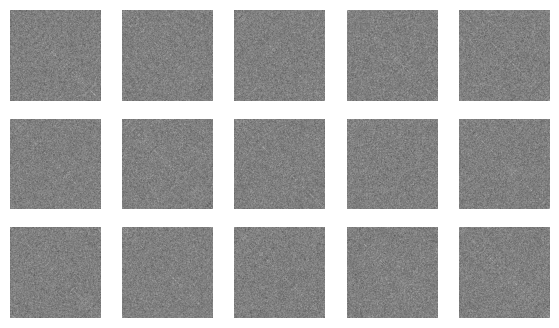

Clique size values:
[300 271 242 227 213 198 184 169 155 143 131 118 106  94  82  57  33]
p_corrected values:
[0.45067634 0.46048411 0.46900002 0.47293336 0.47632946 0.47968425
 0.4825593  0.48537412 0.48776061 0.48962597 0.49132866 0.49299326
 0.49436667 0.495586   0.49665343 0.49839728 0.49947091]
Fraction of correct responses:
0.13333333333333333


In [6]:
# test of model on task instance
N_value = 1000   #CHANGE THIS
clique_size_fraction = 0.05 # CHANGE THIS
capacity = 0.2  #CHANGE THIS
print("Clique size of: ", int(clique_size_fraction*N_value), " in a graph of size: ", N_value)
# visualizing input for 15 graphs, "p_reduce"
graphs_with_clique = graphs_gen.generate_batch(15, N_value, np.repeat([int(clique_size_fraction*N_value)],15), "p_reduce", False, p_clique=1)
# Show 15 graphs
fig, axes = plt.subplots(3, 5, figsize=(7, 4))
for i in range(15):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(np.squeeze(graphs_with_clique[0][i]), cmap='gray_r')
    axes[row, col].axis('off')
plt.show()
# testing ideal observer on this graph:
clique_size_values = K_grid_human_exps[N_value]
p_corrected_values = p_correction(0.5, N_value, clique_size_values)

# DEBUGGING
print("Clique size values:")
print(clique_size_values)
print("p_corrected values:")
print(p_corrected_values)

decision_variable = ideal_observer_k_not_known_limited_capacity(graphs_with_clique[0], N_value, clique_size_values, p_corrected_values, capacity)
print("Fraction of correct responses:")
print(np.sum(decision_variable == graphs_with_clique[1]) / 15)

### Testing

In [ ]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-observer_test_config.yml")
)
capacity_values = config["testing_parameters"]["capacity_values"]

for capacity in capacity_values:  
    # looping over the different graph sizes in the experiment:
    for graph_size in config["graph_size_values"]:

        # defining priors for clique sizes at current graph size (aligned with grid for human experiment)
        clique_size_values = K_grid_human_exps[graph_size]
        print("Clique size values for prior: ", clique_size_values)
        # defining corresponding p_corrected values:
        p_corrected_values = p_correction(0.5, graph_size, clique_size_values)
        print(f"P-corrected values for each clique size value (N={graph_size}): {p_corrected_values}")
        
        # Create empty dictionaries for storing testing results:
        fraction_correct_results = {}  # Fraction correct for each clique size
        metrics_results_list = []

        # Calculate max clique size for testing (proportion of graph size):
        if graph_size in [100, 150, 200]:
            max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][0]
        elif graph_size in [300, 400, 480, 600]:
            max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][1]
        else:
            max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][2]                        
        max_clique_size = int(
            max_clique_size_proportion_test * graph_size
        )

        # Calculate array of clique sizes for all test curriculum
        # NOTE: if max clique size is smaller than the the number of test levels, use max clique size as the number of test levels
        clique_sizes = np.linspace(
            max_clique_size,
            1,
            num=min(max_clique_size, config["testing_parameters"]["clique_testing_levels"]),
        ).astype(int)

        # Loop for decreasing clique sizes
        for current_clique_size in clique_sizes:

            # Metrics initialization (for each clique size)
            TP, FP, TN, FN = 0, 0, 0, 0  

            # Initialize fraction correct list, updated at each test iteration
            fraction_correct_list = []

            # Loop for testing iterations:
            for test_iter in range(config["testing_parameters"]["test_iterations"]):

                # Generate clique size value of each graph in the current batch
                clique_size_array_test = graphs_gen.generate_batch_clique_sizes(
                    np.array([current_clique_size]),
                    config["testing_parameters"]["num_test"],
                )

                # Generate validation graphs
                test = graphs_gen.generate_batch(
                    config["testing_parameters"]["num_test"],
                    graph_size,
                    clique_size_array_test,
                    config["p_correction_type"],
                    False,
                )
                            
                hard_output = ideal_observer_k_not_known_limited_capacity(test[0], graph_size, clique_size_values, p_corrected_values, capacity)
                test_labels = np.array(test[1]) # convert list to numpy array
                # print(hard_output.shape, test_labels.shape)   # DEBUGGING

                # transforming hard_output and test_labels to torch tensors:
                hard_output = torch.tensor(hard_output, dtype=torch.float32)
                test_labels = torch.tensor(test[1], dtype=torch.float32)
                
                # Compute metrics
                TP += ((hard_output == 1) & (test_labels == 1)).sum().item()
                FP += ((hard_output == 1) & (test_labels == 0)).sum().item()
                TN += ((hard_output == 0) & (test_labels == 0)).sum().item()
                FN += ((hard_output == 0) & (test_labels == 1)).sum().item()

                # updating fraction correct list with the accuracy of the current test iteration:
                fraction_correct_list.append(
                    (hard_output == test_labels).sum().item()
                    / (1.0 * config["testing_parameters"]["num_test"])
                )

            # Updating dictionary after all test iterations for current clique size have been completed:
            fraction_correct_results[current_clique_size] = round(
                sum(fraction_correct_list) / len(fraction_correct_list), 2
            )
            
            # Computing metrics:
            precision = TP / (TP + FP + 1e-10)
            recall = TP / (TP + FN + 1e-10)
            F1 = 2 * (precision * recall) / (precision + recall + 1e-10)
            # AUC - ROC cannot be calculated (no soft outputs)
            # num_params has no meaning
            metrics_results = {
                "N_value": graph_size,
                "clique_size": current_clique_size,
                "TP": TP,
                "FP": FP,
                "TN": TN,
                "FN": FN,
                "precision": precision,
                "recall": recall,
                "F1": F1,
            }
            metrics_results_list.append(metrics_results)

            # Printing the size of the clique just tested and the corresponding test accuracy:
            print(
                f"||| Completed testing for clique = {current_clique_size}. "
                f"Average fraction correct = {fraction_correct_results[current_clique_size]}"
            )
            print("|||===========================================================")


        # - notify completion of testing:
        print(f"| Finished testing Ideal observer at N = {graph_size}.")

        # Saving accuracy results in .csv file:
        capacity_string = str(capacity).replace('.', '-')
        # - defining file name and path:
        file_path = os.path.join(
            os.getcwd(), "results", "ideal-observer-k-not-known_human-grid_limited-capacity", f"capacity_{capacity_string}", f"Ideal-observer-k-not-known_human-grid_limited-capacity-{capacity_string}_N{graph_size}_fraction_correct.csv"
        )
        # - saving the dictionary as a .csv file:
        with open(file_path, "w") as file:
            writer = csv.writer(file)
            writer.writerow(["clique size", "fraction correct"])  # Add column labels
            for key, value in fraction_correct_results.items():
                writer.writerow([key, value])
        # Saving metrics results in .csv file:
        metrics_df = pd.DataFrame(metrics_results_list)    
        # - defining file name and path:
        file_path = os.path.join(
            os.getcwd(), "results", "ideal-observer-k-not-known_human-grid_limited-capacity", f"capacity_{capacity_string}", f"Ideal-observer-k-not-known_human-grid_limited-capacity-{capacity_string}_N{graph_size}_metrics.csv"
        )
        metrics_df.to_csv(file_path, index=False)

        print(f"- Ideal observer Results (human grid with limited capacity) saved successfully for N = {graph_size}.")

Configuration file loaded successfully.
Clique size values for prior:  [300 271 242 227 213 198 184 169 155 143 131 118 106  94  82  57  33]
P-corrected values for each clique size value (N=1000): [0.45067634 0.46048411 0.46900002 0.47293336 0.47632946 0.47968425
 0.4825593  0.48537412 0.48776061 0.48962597 0.49132866 0.49299326
 0.49436667 0.495586   0.49665343 0.49839728 0.49947091]
||| Completed testing for clique = 120. Average fraction correct = 0.99
|||===========================================================
||| Completed testing for clique = 118. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 117. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 116. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 115. Average fraction correct = 1.0
|||=

### Metrics analysis (TO IMPLEMENT)

## K matched with K grid in human experiments (fixed maximum capacity)

### Definitions

In [8]:
# defining grid of K values (sqrt-grid) used in human experiments:
K_grid_human_exps = {
    100: np.array([58, 52, 47, 44, 41, 38, 35, 33, 30, 28, 25, 23, 20, 18, 16, 11,  6]),
    150: np.array([90, 82, 73, 68, 64, 60, 55, 51, 47, 43, 39, 36, 32, 28, 25, 17, 10]),
    200: np.array([114, 103,  92,  86,  81,  75,  70,  64,  59,  54,  50,  45, 40, 36,  31,  22,  13]),
    300: np.array([150, 136, 121, 114, 107,  99,  92,  85,  78,  72,  66,  59,  53, 47,  41,  29,  17]),
    400: np.array([180, 162, 145, 136, 127, 118, 110, 101,  93,  86,  78,  71,  63, 56,  49,  34,  20]),
    480: np.array([200, 181, 161, 151, 142, 132, 123, 113, 103,  95,  87,  79,  71, 63,  55,  38,  22]),
    600: np.array([227, 205, 183, 172, 161, 150, 139, 128, 117, 108,  99,  89,  80, 71,  62,  43,  25]),
    800: np.array([266, 240, 215, 201, 189, 176, 163, 150, 137, 127, 116, 105,  94, 83,  73,  51,  29]),
    1000: np.array([300, 271, 242, 227, 213, 198, 184, 169, 155, 143, 131, 118, 106, 94,  82,  57,  33])
}
print(K_grid_human_exps[100])

[58 52 47 44 41 38 35 33 30 28 25 23 20 18 16 11  6]


The model is an adaptation of `ideal_observer_k_not_known` that has a fixed "max_capacity" parameter, that indicates the maximum number of nodes which degree is sampled and computed. In the cases where $N \leq \text{max\_capacity}$, all the nodes are sampled; in the other cases, "max_capacity" nodes are extracted and the corresponding degree is computed.

In [9]:
def ideal_observer_k_not_known_max_capacity(graphs_batch, graph_size, clique_size_values, p_corrected_values, max_capacity=150):
    # Description:
    # This model is an adaptation of `ideal_observer_k_not_known` with a "max_capacity" parameter that defines the maximum number of nodes which degree is sampled and computed.
    # NOTE: "clique_size_values" and "p_corrected_values" are arrays of the possible K values and the corresponding p_corrected values    
    
    rng = np.random.default_rng()
    
    if not isinstance(max_capacity, int) or (max_capacity <= 0):
        raise ValueError("max_capacity must be a positive integer")    
    
    batch_size = len(graphs_batch)
    n_clique_size_values = len(clique_size_values)
    
    # Calculate full degree and apply mask only if graph_size > max_capacity:
    degrees_full = np.array(torch.sum(graphs_batch, dim=2))  # shape: (batch_size, 1, graph_size)    
    if graph_size <= max_capacity:
        degrees_masked = degrees_full
    else:
        # For each graph in the batch, selection of "max_capacity" unique indices
        selected_indices = np.array([
            rng.choice(graph_size, size=max_capacity, replace=False)
            for _ in range(batch_size)
        ])  # shape: (batch_size, max_capacity)
        # Build mask (will be True for selected nodes, False otherwise)
        node_masks = np.zeros((batch_size, 1, graph_size), dtype=bool)
        # Set selected indices to True
        batch_indices = np.arange(batch_size)[:, None]
        node_masks[batch_indices, 0, selected_indices] = True
        degrees_masked = np.where(node_masks, degrees_full, np.nan)
        
    # # DEBUGGING:
    # non_nan_counts = np.sum(~np.isnan(degrees_masked), axis=2)
    # print(f"DEBUGGING: Non-nan node counts per graph (should all be {max_capacity}):")
    # print(non_nan_counts)    
    
    # broadcasting degrees so that they can be used in formula for different clique size values
    degrees_broadcast = np.broadcast_to(degrees_masked, (batch_size, n_clique_size_values, graph_size)) # shape: (batch_size, n_clique_size_values, graph_size)
    # reshaping clique size values so that they can be broadcasted
    clique_size_values_broadcast = np.reshape(clique_size_values, (1, n_clique_size_values, 1))  # shape: (1, n_clique_size_values, 1)  
    # reshaping p_corrected so that it can be broadcasted
    p_corrected_broadcast = np.reshape(p_corrected_values, (1, n_clique_size_values, 1))  # shape: (1, n_clique_size_values, 1)  
    
    # Compute degree distributions (nodes that were masked out generate "nans" at this point, and do not contribute to the sum) 
    sigma_kprime = np.nansum(
        np.log(degree_distribution_clique(
            degrees_broadcast, graph_size, clique_size_values_broadcast, p_corrected_broadcast
        )),
        axis=2  # sum over nodes
    )  # shape: (batch_size, n_clique_size_values) -> all negative values
    
    sigma_star = np.max(sigma_kprime, axis=1, keepdims=True)   # maximum over "clique size" axis (shape: (15, 1) )
    
    # computing p_clique:   
    p_clique = sigma_star + np.log(np.sum(np.exp(sigma_kprime - sigma_star), axis = 1, keepdims=True)) - np.log(n_clique_size_values)  # shape: (batch_size, 1)
    
    # sanity check to make sure p_clique has no +/- inf:
    if p_clique.dtype == np.float64:
        if np.isinf(p_clique).any() or np.isnan(p_clique).any():
            raise ValueError("p_clique contains inf or NaN values, check numerical stability and logsumexp effectiveness.")
    
    # # DEBUGGING
    # print("Clique probabilities for all graphs:")
    # print(p_clique.squeeze())
    # print("No clique probabilities for all graphs:")
    # print(np.nansum(degree_distribution_noclique(degrees_masked, graph_size), 2).squeeze())

    # computing decision variable
    decision_variable = p_clique.squeeze() - np.nansum(degree_distribution_noclique(degrees_masked, graph_size), 2).squeeze()
    # Convert values > 0 to 1, values <= 0 to 0
    hard_output = (decision_variable > 0).astype(int)

    # # DEBUGGING
    # print("Hard output:")
    # print(hard_output)

    return hard_output.squeeze()

Clique size of:  50  in a graph of size:  1000


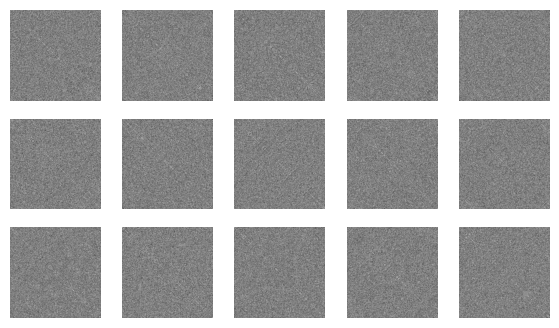

Clique size values:
[300 271 242 227 213 198 184 169 155 143 131 118 106  94  82  57  33]
p_corrected values:
[0.45067634 0.46048411 0.46900002 0.47293336 0.47632946 0.47968425
 0.4825593  0.48537412 0.48776061 0.48962597 0.49132866 0.49299326
 0.49436667 0.495586   0.49665343 0.49839728 0.49947091]
Fraction of correct responses:
0.2


In [10]:
# test of model on task instance
N_value = 1000   #CHANGE THIS
clique_size_fraction = 0.05 # CHANGE THIS
max_capacity = 150  #CHANGE THIS
print("Clique size of: ", int(clique_size_fraction*N_value), " in a graph of size: ", N_value)
# visualizing input for 15 graphs, "p_reduce"
graphs_with_clique = graphs_gen.generate_batch(15, N_value, np.repeat([int(clique_size_fraction*N_value)],15), "p_reduce", False, p_clique=1)
# Show 15 graphs
fig, axes = plt.subplots(3, 5, figsize=(7, 4))
for i in range(15):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(np.squeeze(graphs_with_clique[0][i]), cmap='gray_r')
    axes[row, col].axis('off')
plt.show()
# testing ideal observer on this graph:
clique_size_values = K_grid_human_exps[N_value]
p_corrected_values = p_correction(0.5, N_value, clique_size_values)

# DEBUGGING
print("Clique size values:")
print(clique_size_values)
print("p_corrected values:")
print(p_corrected_values)

decision_variable = ideal_observer_k_not_known_max_capacity(graphs_with_clique[0], N_value, clique_size_values, p_corrected_values, max_capacity)
print("Fraction of correct responses:")
print(np.sum(decision_variable == graphs_with_clique[1]) / 15)

### Testing

In [ ]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-observer_test_config.yml")
)
max_capacity_values = config["testing_parameters"]["max_capacity_values"]

for max_capacity in max_capacity_values:  
    # looping over the different graph sizes in the experiment:
    for graph_size in config["graph_size_values"]:

        # defining priors for clique sizes at current graph size (aligned with grid for human experiment)
        clique_size_values = K_grid_human_exps[graph_size]
        print("Clique size values for prior: ", clique_size_values)
        # defining corresponding p_corrected values:
        p_corrected_values = p_correction(0.5, graph_size, clique_size_values)
        print(f"P-corrected values for each clique size value (N={graph_size}): {p_corrected_values}")
        
        # Create empty dictionaries for storing testing results:
        fraction_correct_results = {}  # Fraction correct for each clique size
        metrics_results_list = []

        # Calculate max clique size for testing (proportion of graph size):
        if graph_size in [100, 150, 200]:
            max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][0]
        elif graph_size in [300, 400, 480, 600]:
            max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][1]
        else:
            max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"][2]                        
        max_clique_size = int(
            max_clique_size_proportion_test * graph_size
        )

        # Calculate array of clique sizes for all test curriculum
        # NOTE: if max clique size is smaller than the the number of test levels, use max clique size as the number of test levels
        clique_sizes = np.linspace(
            max_clique_size,
            1,
            num=min(max_clique_size, config["testing_parameters"]["clique_testing_levels"]),
        ).astype(int)

        # Loop for decreasing clique sizes
        for current_clique_size in clique_sizes:

            # Metrics initialization (for each clique size)
            TP, FP, TN, FN = 0, 0, 0, 0  

            # Initialize fraction correct list, updated at each test iteration
            fraction_correct_list = []

            # Loop for testing iterations:
            for test_iter in range(config["testing_parameters"]["test_iterations"]):

                # Generate clique size value of each graph in the current batch
                clique_size_array_test = graphs_gen.generate_batch_clique_sizes(
                    np.array([current_clique_size]),
                    config["testing_parameters"]["num_test"],
                )

                # Generate validation graphs
                test = graphs_gen.generate_batch(
                    config["testing_parameters"]["num_test"],
                    graph_size,
                    clique_size_array_test,
                    config["p_correction_type"],
                    False,
                )
                            
                hard_output = ideal_observer_k_not_known_max_capacity(test[0], graph_size, clique_size_values, p_corrected_values, max_capacity)
                test_labels = np.array(test[1]) # convert list to numpy array
                # print(hard_output.shape, test_labels.shape)   # DEBUGGING

                # transforming hard_output and test_labels to torch tensors:
                hard_output = torch.tensor(hard_output, dtype=torch.float32)
                test_labels = torch.tensor(test[1], dtype=torch.float32)
                
                # Compute metrics
                TP += ((hard_output == 1) & (test_labels == 1)).sum().item()
                FP += ((hard_output == 1) & (test_labels == 0)).sum().item()
                TN += ((hard_output == 0) & (test_labels == 0)).sum().item()
                FN += ((hard_output == 0) & (test_labels == 1)).sum().item()

                # updating fraction correct list with the accuracy of the current test iteration:
                fraction_correct_list.append(
                    (hard_output == test_labels).sum().item()
                    / (1.0 * config["testing_parameters"]["num_test"])
                )

            # Updating dictionary after all test iterations for current clique size have been completed:
            fraction_correct_results[current_clique_size] = round(
                sum(fraction_correct_list) / len(fraction_correct_list), 2
            )
            
            # Computing metrics:
            precision = TP / (TP + FP + 1e-10)
            recall = TP / (TP + FN + 1e-10)
            F1 = 2 * (precision * recall) / (precision + recall + 1e-10)
            # AUC - ROC cannot be calculated (no soft outputs)
            # num_params has no meaning
            metrics_results = {
                "N_value": graph_size,
                "clique_size": current_clique_size,
                "TP": TP,
                "FP": FP,
                "TN": TN,
                "FN": FN,
                "precision": precision,
                "recall": recall,
                "F1": F1,
            }
            metrics_results_list.append(metrics_results)

            # Printing the size of the clique just tested and the corresponding test accuracy:
            print(
                f"||| Completed testing for clique = {current_clique_size}. "
                f"Average fraction correct = {fraction_correct_results[current_clique_size]}"
            )
            print("|||===========================================================")


        # - notify completion of testing:
        print(f"| Finished testing Ideal observer at N = {graph_size}.")

        # Saving accuracy results in .csv file:
        max_capacity_string = str(max_capacity)
        # - defining file name and path:
        file_path = os.path.join(
            os.getcwd(), "results", "ideal-observer-k-not-known_human-grid_max-capacity", f"max_capacity_{max_capacity_string}", f"Ideal-observer-k-not-known_human-grid_max-capacity-{max_capacity_string}_N{graph_size}_fraction_correct.csv"
        )
        # - saving the dictionary as a .csv file:
        with open(file_path, "w") as file:
            writer = csv.writer(file)
            writer.writerow(["clique size", "fraction correct"])  # Add column labels
            for key, value in fraction_correct_results.items():
                writer.writerow([key, value])
        # Saving metrics results in .csv file:
        metrics_df = pd.DataFrame(metrics_results_list)    
        # - defining file name and path:
        file_path = os.path.join(
            os.getcwd(), "results", "ideal-observer-k-not-known_human-grid_max-capacity", f"max_capacity_{max_capacity_string}", f"Ideal-observer-k-not-known_human-grid_max-capacity-{max_capacity_string}_N{graph_size}_metrics.csv"
        )
        metrics_df.to_csv(file_path, index=False)

        print(f"- Ideal observer Results (human grid with maximum capacity) saved successfully for N = {graph_size}.")

Configuration file loaded successfully.
Clique size values for prior:  [300 271 242 227 213 198 184 169 155 143 131 118 106  94  82  57  33]
P-corrected values for each clique size value (N=1000): [0.45067634 0.46048411 0.46900002 0.47293336 0.47632946 0.47968425
 0.4825593  0.48537412 0.48776061 0.48962597 0.49132866 0.49299326
 0.49436667 0.495586   0.49665343 0.49839728 0.49947091]
||| Completed testing for clique = 120. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 118. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 117. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 116. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 115. Average fraction correct = 0.99
|||=

### Metrics analysis (TO IMPLEMENT)